(Thermonets)=

# ThermoNETs

```{note}
For an introduction on feed forward neural networks in *heyoka.py*, check out the example: [Feed-Forward Neural Networks](<./ffnn.ipynb>).
```

Where we show the use of the neural thermospheric models provided in *heyoka.py*. These are implicit neural representations of the thermospheric density which have been developed in the paper:

*Izzo, Dario*, *Giacomo Acciarini*, and *Francesco Biscani* "NeuralODEs for VLEO simulations: Introducing thermoNET for Thermosphere Modeling" ([arXiv preprint](https://arxiv.org/abs/2405.19384))

and which are called [thermoNETs](https://github.com/esa/thermonets). The models are differentiable versions of the widely used [NRLMSISE00](https://ccmc.gsfc.nasa.gov/models/NRLMSIS~00/) and [JB08](https://ccmc.gsfc.nasa.gov/models/JB2008~2008/) atmospheric models, condensing in one, albeit large, *heyoka* expression the entire models.

In [1]:
# The usual main imports
import heyoka as hy
import numpy as np
import datetime
import spaceweather as sw
import time

%matplotlib inline
import matplotlib.pyplot as plt

Atmospheric models depend on a large number of space weather indices. These can be obtained from various online resources, in the python ecosystem we may for example recommend [spaceweather](https://pypi.org/project/spaceweather/) and [pyatmos](https://pypi.org/project/pyatmos/). Another option is the use of heyoka.py's support for [space weather data](<./sw_data.ipynb>).

Regardless of the tools used to get the actual values of the various space indices used, we now define all necessary variables to call our neural thermospheric models. Note that for NRLMSISE00 only $F_{10.7}$, its average, and the $AP$ index are needed. Note also how $h, lat, lon$ are the geodetic coordinates.


In [2]:
h, lat, lon, f107, f107a, s107, s107a, m107, m107a, y107, y107a, ap, dDstdT = (
    hy.make_vars(
        "h",
        "lat",
        "lon",
        "f107",
        "f107a",
        "s107",
        "s107a",
        "m107",
        "m107a",
        "y107",
        "y107a",
        "ap",
        "dDstdT",
    )
)

Time to instantiate the models! Let us start with nrlmsise00:

In [3]:
# Symbolic expression
nrlmsise00 = hy.model.nrlmsise00_tn(
    geodetic=[h, lat, lon], f107=f107, f107a=f107a, ap=ap, time_expr=hy.time
)

# Compiled function
nrlmsise00_cf = hy.cfunc([nrlmsise00], vars=[h, lat, lon, f107, f107a, ap])

... and do the same for JB08

In [4]:
# Symbolic expression
jb08 = hy.model.jb08_tn(
    geodetic=[h, lat, lon],
    f107=f107,
    f107a=f107a,
    s107=s107,
    s107a=s107a,
    m107=m107,
    m107a=m107a,
    y107=y107,
    y107a=y107a,
    dDstdT=dDstdT,
    time_expr=hy.time,
)

# Compiled function
jb08_cf = hy.cfunc(
    [jb08],
    vars=[
        h,
        lat,
        lon,
        f107a,
        f107,
        s107a,
        s107,
        m107a,
        m107,
        y107a,
        y107,
        dDstdT,
    ],
)

Note how in both cases we passed as the *time* kwarg {py:attr}`heyoka.time`, which we are assuming to represent directly the fractional days since January 1st.

Let us now visualize the difference between the models calling the compiled function over a range of altitudes (assumed in km). For the purpose of this quick comparison, we are choosing the value $10$ for all space weather data (as we do not care here to have meaningful predictions, only a quick comparative plot). We also fix longitude and latitude to $45^o$ and $-120^o$, and we span altitudes from 200 to 500 kilometers.

In [5]:
N = 100
hs = list(np.linspace(200.0, 500.0, N))
lon = 45.0 / 180 * np.pi
lat = -120.2 / 180 * np.pi
sol_n = nrlmsise00_cf(
    inputs=[hs, [lat] * N, [lon] * N, [10.0] * N, [10.0] * N, [10] * N], time=[56.0] * N
)
sol_j = jb08_cf(
    inputs=[
        hs,
        [lat] * N,
        [lon] * N,
        [10.0] * N,
        [10.0] * N,
        [10.0] * N,
        [10.0] * N,
        [10.0] * N,
        [10.0] * N,
        [10.0] * N,
        [10.0] * N,
        [10] * N,
    ],
    time=[56.0] * N,
)

Let us visualise the trends:

Mean Absolute Percentage Difference:  18.087804208309393


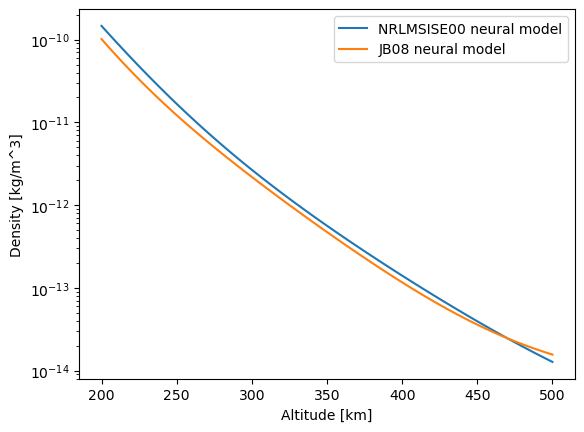

In [6]:
MAPE = np.mean(np.abs(sol_n - sol_j) / sol_n) * 100
plt.semilogy(hs, sol_n.ravel(), label="NRLMSISE00 neural model")
plt.semilogy(hs, sol_j.ravel(), label="JB08 neural model")
plt.legend()
plt.xlabel("Altitude [km]")
plt.ylabel("Density [kg/m^3]")
print(f"Mean Absolute Percentage Difference: ", MAPE)

As expected, the mean absolute percentage difference between the two neural models is quite high, as it should be since the models themselves are quite different!

## Using thermoNETs in numerical propagations

We assume the only forces acting on the satellite are the air drag and the gravitational attraction to a central body. 

The resulting equations of motion, in an inertial frame, are:

$$
\begin{array}{l}
\ddot{\mathbf r} = -\dfrac{\mu}r^3 \mathbf r -\dfrac {A\rho(\mathbf r, t)}{2m} C_d |\mathbf v - \omega\times \mathbf r|(\mathbf v - \omega \mathbf r),
\end{array}
$$

where we have considered an atmosphere rigidly rotating with the Earth (i.e., no winds accounted for).

We also assume to have the initial conditions given at the calendar date 22nd of June 2009, at 06:32:12:00 GMT.

### Defining the propagation data

In [7]:
# Initial epoch
date0 = datetime.datetime(2009, 6, 22, 6, 32, 0, 0)

# First we need to set some variables useful for integration:
mu = 3.986004407799724e14  # Earth gravitational parameter SI
r_earth = 6378137  # Earth radius SI
initial_h = 300.0 * 1e3  # Satellite's initial altitude SI
mass = 200  # mass of the satellite SI
area = 2  #                     drag cross-sectional area of the satellite in SI
cd = 2.2  #                     drag coefficient [-]
bc = mass / (cd * area)  # ballistic coefficient in SI
omega = 7.2921159e-5  # Earth rotation speed in SI (sidereal)

# We assume a circular orbit at first
initial_conditions = [
    r_earth + initial_h,
    0.0,
    0.0,
    0.0,
    np.sqrt(mu / (r_earth + initial_h)),
    0.0,
]
# ... and 90 days of propagation
t_grid = np.linspace(0.0, 60.0 * 60.0 * 24 * 60.0, 700)

In order to be able to transform the Cartesian coordinates from an [ECI to an ECEF reference frame](https://en.wikipedia.org/wiki/Earth-centered_inertial), that is to get the Cartesian Coordinates in a non-inertial Earth-fixed frame,
we define an expression for the simple rotation matrix based on the [Earth Rotation Angle (ERA)](https://en.wikipedia.org/wiki/Sidereal_time#ERA)

In [8]:
def ECI2ECEF(mjd):
    """
    This function returns the Earth rotation angle (ERA) at a given Modified Julian Date: https://en.wikipedia.org/wiki/Sidereal_time#ERA.

    Args:
        - mjd_date (`float`): modified julian date

    Returns:
        - `list`: Earth rotation matrix
    """
    era = (
        2
        * np.pi
        * (0.7790572732640 + 1.00273781191135448 * (mjd + 2400000.5 - 2451545.0))
    )
    R = [[hy.cos(era), hy.sin(era), 0], [-hy.sin(era), hy.cos(era), 0], [0, 0, 1]]
    return R

### Defining the epochs
In our dynamical system, the time variable {py:attr}`heyoka.time` will be measured in seconds, and it will represent the time elapsed since the initial conditions. 

We thus need to define few time expressions to compute the corresponding MJD (Modified Julian Date) and the fractional day of the year (DOY). The first is used to convert to the ECEF frame and thus get geodetic coordinates, the second to define the seasonal effects in the thermoNETs interfaces.

In [9]:
# First an expression for the MJD
days_elapsed = hy.time / 86400
mjd0 = date0 - datetime.datetime(2000, 1, 1, 12, 0, 0)
mjd0 = mjd0.days + mjd0.seconds / 86400
mjd = mjd0 + days_elapsed
print("MJD expression: ", mjd)

# Then for the DOY
doy0 = date0 - datetime.datetime(date0.year, 1, 1, 0, 0, 0)
doy0 = doy0.days + doy0.seconds / 86400
doy = doy0 + days_elapsed
print("DOY expression: ", doy)

MJD expression:  (3459.7722222222224 + (1.1574074074074073e-05 * t))
DOY expression:  (172.27222222222221 + (1.1574074074074073e-05 * t))


### Defining the spaceweather indices

To find the needed space weather indices we use the python package [spaceweather](https://pypi.org/project/spaceweather/) and consider their value as constant values. This last hypothesis can be easily removed
assembling, instead, expressions modelling the time variations of the indices in the considered period.

In [10]:
# We get the spaceweather data
sw.update_data()
sw_data = sw.sw_daily()
ap_data = sw_data[["Apavg"]]
f107_data = sw_data[["f107_obs"]]
f107a_data = sw_data[["f107_81ctr_obs"]]

In [11]:
# We compute the indices at the initial date (they will be considered here as constant)
ap = ap_data.loc[f"{int(date0.year)}-{int(date0.month)}-{int(date0.day)}"].values[0]
f107 = f107_data.loc[f"{int(date0.year)}-{int(date0.month)}-{int(date0.day)}"].values[0]
f107a = f107a_data.loc[f"{int(date0.year)}-{int(date0.month)}-{int(date0.day)}"].values[
    0
]
ap = hy.expression(ap)
f107 = hy.expression(f107)
f107a = hy.expression(f107a)

### Defining the dynamics

In [12]:
# We instantiate the state variables as heyoka variables:
x, y, z, vx, vy, vz = hy.make_vars("x", "y", "z", "vx", "vy", "vz")
# We compute the expression for the ECI 2 ECEF rotation matrix
xyz_ecef = np.matmul(ECI2ECEF(mjd), [x, y, z])
# We compute the geodetic coordinates
h, lat, lon = hy.model.cart2geo([xyz_ecef[0], xyz_ecef[1], xyz_ecef[2]])
# And the dynamics
density_nn = hy.model.nrlmsise00_tn(
    geodetic=[h / 1000, lat, lon], f107=f107, f107a=f107a, ap=ap, time_expr=doy
)
akepler_x = -mu * x * (x**2 + y**2 + z**2) ** (-3 / 2)
akepler_y = -mu * y * (x**2 + y**2 + z**2) ** (-3 / 2)
akepler_z = -mu * z * (x**2 + y**2 + z**2) ** (-3 / 2)

vrel_x = vx + omega * y
vrel_y = vy - omega * x
adragx = -1 / 2 * density_nn * vx * hy.sqrt(vrel_x**2 + vrel_y**2 + vz**2) / bc
adragy = -1 / 2 * density_nn * vy * hy.sqrt(vrel_x**2 + vrel_y**2 + vz**2) / bc
adragz = -1 / 2 * density_nn * vz * hy.sqrt(vrel_x**2 + vrel_y**2 + vz**2) / bc

dynamics = [
    (x, vx),
    (y, vy),
    (z, vz),
    (vx, akepler_x + adragx),
    (vy, akepler_y + adragy),
    (vz, akepler_z + adragz),
]

### Instantiating the adaptive Taylor integrator

In [13]:
start_time = time.time()
ta = hy.taylor_adaptive(
    dynamics,
    initial_conditions,
    compact_mode=True,
)
print(f"{time.time() - start_time} to build the integrator")

0.7306873798370361 to build the integrator


### Propagating the dynamics for 60 days

In [14]:
start_time = time.time()
ta.state[:] = initial_conditions
ta.time = 0.0
sol_heyoka_nn = ta.propagate_grid(t_grid)
print(f"{time.time() - start_time} to propagate for 60 days")

0.675147294998169 to propagate for 60 days


### Visualizing the re-entry trajectory

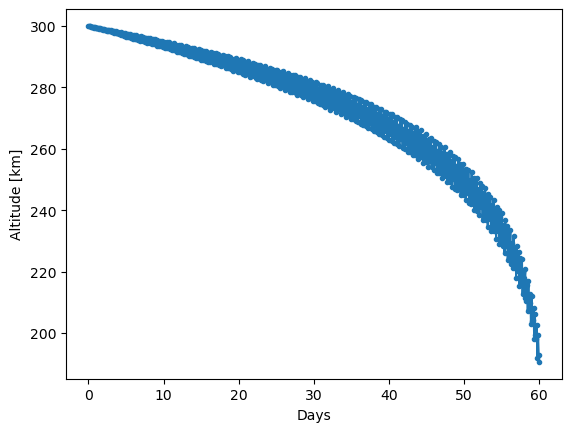

In [15]:
plt.plot(
    t_grid / 24 / 60 / 60,
    np.sqrt(
        sol_heyoka_nn[-1][:, 0] ** 2
        + sol_heyoka_nn[-1][:, 1] ** 2
        + sol_heyoka_nn[-1][:, 2] ** 2
    )
    / 1e3
    - r_earth / 1e3,
    marker=".",
)
plt.ylabel("Altitude [km]")
plt.xlabel("Days");